<a href="https://colab.research.google.com/github/NorhanM-A/Mega-Project/blob/main/FinalCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile

# Specify the path to your zip file
zip_file_path = "/content/test_filtered.zip"

# Specify the directory where you want to extract the contents
extracted_dir = "data"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
import os
print("Contents of the extracted directory:")
for item in os.listdir(extracted_dir):
    if os.path.isdir(os.path.join(extracted_dir, item)):
        print(f"Directory: {item}")
    else:
        print(f"File: {item}")


Contents of the extracted directory:
Directory: test_filtered


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [ ]:
!pip install opencv-python-headless scikit-learn numpy


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [ ]:
#CROPPING IMAGES



import cv2
import os

# Define the directory containing images
image_dir = '/content/data/test_filtered/filtered_images'

# Define the directory containing label text files
label_dir = '/content/data/test_filtered/filtered_labels'

# Define the output directory to save the cropped images
output_dir = 'cropped_images/'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get a list of image file paths
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Iterate over each image file
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read label data from the corresponding text file
    with open(label_path, 'r') as label_file:
        for line in label_file:
            values = list(map(float, line.split()[1:]))  # Ignore the first value (class number)

            if len(values) != 4:
                print(f"Invalid label format for {image_file}")
                continue

            x_center, y_center, width, height = values

            # Calculate x1, y1, x2, and y2 from bounding box information
            x1 = int((x_center - width / 2) * image.shape[1])
            y1 = int((y_center - height / 2) * image.shape[0])
            x2 = int((x_center + width / 2) * image.shape[1])
            y2 = int((y_center + height / 2) * image.shape[0])

            # Ensure the coordinates are within image boundaries
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(x2, image.shape[1]), min(y2, image.shape[0])

            if x1 >= x2 or y1 >= y2:
                print(f"Invalid coordinates for {image_file}")
                continue

            # Crop the region
            cropped = image[y1:y2, x1:x2]

            # Save the cropped image with label_name in the output directory
            output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}.jpg')
            cv2.imwrite(output_path, cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR))

print("Cropping and saving complete.")


Cropping and saving complete.


In [ ]:
#REMOVING THE BACKGROUND



import cv2
import os
import numpy as np

# Define the directory containing images
image_dir = '/content/cropped_images'

# Define the output directory to save the images with background removed
output_dir = 'background_removed_images/'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def remove_background_grabcut(image):
    # Create a mask for the foreground
    mask = np.zeros(image.shape[:2], np.uint8)

    # Initialize background and foreground models
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # Define a rectangle that includes the entire image
    rect = (1, 1, image.shape[1] - 1, image.shape[0] - 1)

    # Interactive GrabCut: Allow the user to mark foreground and background
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # Create a mask for the user-defined foreground and background
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Multiply the original image with the binary mask to remove the background
    result = image * mask2[:, :, np.newaxis]

    return result

# Get a list of image file paths
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Iterate over each image file
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Remove the background using GrabCut
    bg_removed_image = remove_background_grabcut(image)

    # Save the image with background removed to the output directory
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, cv2.cvtColor(bg_removed_image, cv2.COLOR_RGB2BGR))

print("Background removal and saving complete.")


Background removal and saving complete.


In [ ]:
#DILATING IMAGES

import cv2
import os
import numpy as np

# Define input and output directories
input_dir = '/content/background_removed_images'
output_dir = 'dilated_images/'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def apply_dilation(image):
    # Apply dilation to the image
    kernel_size = (3, 3)  # Adjust the kernel size as needed
    iterations = 2  # Increase the number of iterations
    border_color = (255, 255, 255)  # Change border handling to constant white

    kernel = np.ones(kernel_size, np.uint8)
    dilated = cv2.dilate(image, kernel, iterations=iterations, borderType=cv2.BORDER_CONSTANT, borderValue=border_color)
    return dilated

# Load all image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]

for image_file in image_files:
    # Load the image
    image_path = os.path.join(input_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply dilation
    dilated_image = apply_dilation(image)

    # Save the dilated image to the output directory
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, cv2.cvtColor(dilated_image, cv2.COLOR_RGB2BGR))

print("Dilation and saving complete.")


Dilation and saving complete.


In [ ]:
#BLURRING IMAGES



import cv2
import os

# Define input and output directories
input_dir = '/content/background_removed_images'
output_dir = 'blurred_images/'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def apply_blur(image):
    # Apply Gaussian blur to the image
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred

# Load all image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]

for image_file in image_files:
    # Load the image
    image_path = os.path.join(input_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply Gaussian blur
    blurred_image = apply_blur(image)

    # Save the blurred image to the output directory
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, cv2.cvtColor(blurred_image, cv2.COLOR_RGB2BGR))

print("Blurring and saving complete.")


Blurring and saving complete.


In [ ]:
#COLOR INTENSIFYING


import cv2
import os
import numpy as np

# Define the input and output directories
input_dir = '/content/dilated_images'
output_dir = 'intensified_images/'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the saturation factor for color intensification
saturation_factor = 2 # Adjust this factor to control the intensity

# Get a list of image file paths in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]

for image_file in image_files:
    # Load the image
    image_path = os.path.join(input_dir, image_file)
    image = cv2.imread(image_path)

    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Increase the saturation to intensify colors
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * saturation_factor, 0, 255)

    # Convert the image back to BGR color space
    intensified_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Save the intensified image to the output directory
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, intensified_image)

print("Color intensification complete.")


Color intensification complete.


In [ ]:
#COLOR INTENSIFYING


import cv2
import os
import numpy as np

# Define the input and output directories
input_dir = '/content/blurred_images'
output_dir = 'intensified_images(B)/'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the saturation factor for color intensification
saturation_factor = 2 # Adjust this factor to control the intensity

# Get a list of image file paths in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]

for image_file in image_files:
    # Load the image
    image_path = os.path.join(input_dir, image_file)
    image = cv2.imread(image_path)

    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Increase the saturation to intensify colors
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * saturation_factor, 0, 255)

    # Convert the image back to BGR color space
    intensified_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Save the intensified image to the output directory
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, intensified_image)

print("Color intensification complete.")


Color intensification complete.


In [ ]:
#CLUSTERING DILATED IMAGES


import cv2
import os
import numpy as np
from sklearn.cluster import KMeans

# Define input and output directories
input_dir = '/content/dilated_images'
output_dir = 'clustered_images(D)/'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def cluster_images_kmeans(image, num_clusters):
    # Reshape the image to a 2D array of pixels (height x width, 3)
    pixels = image.reshape(-1, 3)

    # Apply k-means clustering to classify the colors with a max of 1000 iterations and 20 initializations
    kmeans = KMeans(n_clusters=num_clusters, max_iter=2000, n_init=50)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)

    # Reshape labels to the original image shape
    labels = labels.reshape(image.shape[:2])

    # Visualize the clustered image
    clustered_images = [np.zeros_like(image) for _ in range(num_clusters)]

    for i in range(num_clusters):
        clustered_images[i][labels == i] = image[labels == i]

    return clustered_images

# Load all processed image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]

# Parameters for K-Means clustering
num_clusters = 3

for image_file in image_files:
    # Load the processed image
    image_path = os.path.join(input_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Cluster the processed image using K-Means
    clustered_images = cluster_images_kmeans(image, num_clusters)

    # Save the clustered images to the output directory
    for i, cluster_image in enumerate(clustered_images):
        output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}_cluster{i}.jpg')
        cv2.imwrite(output_path, cv2.cvtColor(cluster_image, cv2.COLOR_RGB2BGR))

print("K-means clustering and saving complete.")


K-means clustering and saving complete.


In [ ]:
#CLUSTERING BLURRED/INTENSIFIED IMAGES


import cv2
import os
import numpy as np
from sklearn.cluster import KMeans

# Define input and output directories
input_dir = '/content/dilated_images'
output_dir = '/content/clustered_images(BI)'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def cluster_images_kmeans(image, num_clusters):
    # Reshape the image to a 2D array of pixels (height x width, 3)
    pixels = image.reshape(-1, 3)

    # Apply k-means clustering to classify the colors with a max of 1000 iterations and 20 initializations
    kmeans = KMeans(n_clusters=num_clusters, max_iter=2000, n_init=30)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)

    # Reshape labels to the original image shape
    labels = labels.reshape(image.shape[:2])

    # Visualize the clustered image
    clustered_images = [np.zeros_like(image) for _ in range(num_clusters)]

    for i in range(num_clusters):
        clustered_images[i][labels == i] = image[labels == i]

    return clustered_images

# Load all processed image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]

# Parameters for K-Means clustering
num_clusters = 3

for image_file in image_files:
    # Load the processed image
    image_path = os.path.join(input_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Cluster the processed image using K-Means
    clustered_images = cluster_images_kmeans(image, num_clusters)

    # Save the clustered images to the output directory
    for i, cluster_image in enumerate(clustered_images):
        output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}_cluster{i}.jpg')
        cv2.imwrite(output_path, cv2.cvtColor(cluster_image, cv2.COLOR_RGB2BGR))

print("K-means clustering and saving complete.")


K-means clustering and saving complete.


In [ ]:
#CLUSTERING UNEDITED IMAGES [BEST RESULTS]


import cv2
import os
import numpy as np
from sklearn.cluster import KMeans

# Define input and output directories
input_dir = '/content/background_removed_images'
output_dir = '/content/clustered_images(NORMAL)'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def cluster_images_kmeans(image, num_clusters):
    # Reshape the image to a 2D array of pixels (height x width, 3)
    pixels = image.reshape(-1, 3)

    # Apply k-means clustering to classify the colors with a max of 1000 iterations and 20 initializations
    kmeans = KMeans(n_clusters=num_clusters, max_iter=2000, n_init=30)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)

    # Reshape labels to the original image shape
    labels = labels.reshape(image.shape[:2])

    # Visualize the clustered image
    clustered_images = [np.zeros_like(image) for _ in range(num_clusters)]

    for i in range(num_clusters):
        clustered_images[i][labels == i] = image[labels == i]

    return clustered_images

# Load all processed image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]

# Parameters for K-Means clustering
num_clusters = 3

for image_file in image_files:
    # Load the processed image
    image_path = os.path.join(input_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Cluster the processed image using K-Means
    clustered_images = cluster_images_kmeans(image, num_clusters)

    # Save the clustered images to the output directory
    for i, cluster_image in enumerate(clustered_images):
        output_path = os.path.join(output_dir, f'{os.path.splitext(image_file)[0]}_cluster{i}.jpg')
        cv2.imwrite(output_path, cv2.cvtColor(cluster_image, cv2.COLOR_RGB2BGR))

print("K-means clustering and saving complete.")


K-means clustering and saving complete.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


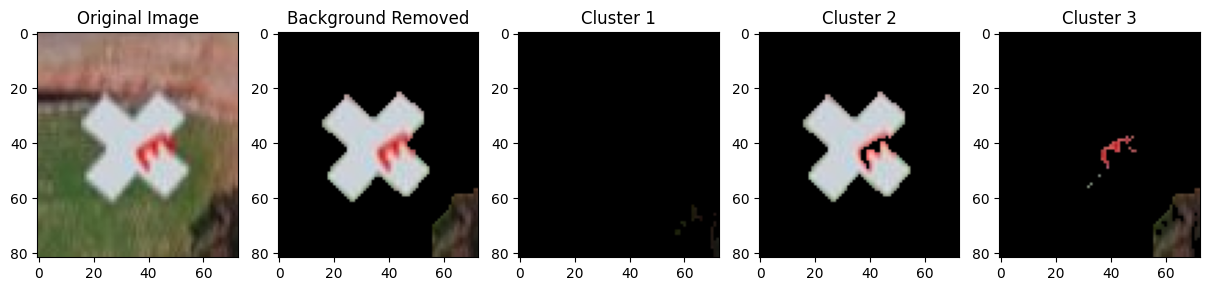

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/content/testimg4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a mask for the foreground (background already removed)
mask = np.zeros(image.shape[:2], np.uint8)

# Initialize background and foreground models
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Define a rectangle that includes the entire image
rect = (1, 1, image.shape[1]-1, image.shape[0]-1)

# Interactive GrabCut: Allow user to mark foreground and background
cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Create a binary mask for the user-defined foreground
mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Multiply the original image with the binary mask to remove the background
result = image * mask[:, :, np.newaxis]

# Reshape the image to a 2D array of pixels (height x width, 3)
pixels = result.reshape(-1, 3)

# Define the number of clusters (e.g., 3 for shape, letter, and background colors)
num_clusters = 3
# Apply k-means clustering to classify the colors
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(pixels)
labels = kmeans.predict(pixels)

# Reshape labels to the original image shape
labels = labels.reshape(image.shape[:2])

# Visualize the clustered image
clustered_images = [np.zeros_like(result) for _ in range(num_clusters)]

for i in range(num_clusters):
    clustered_images[i][labels == i] = result[labels == i]

# Display the original image, background removed image, and clustered images
fig, axes = plt.subplots(1, num_clusters + 2, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[1].imshow(result)
axes[1].set_title("Background Removed")

for i in range(num_clusters):
    axes[i + 2].imshow(clustered_images[i])
    axes[i + 2].set_title(f"Cluster {i + 1}")

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


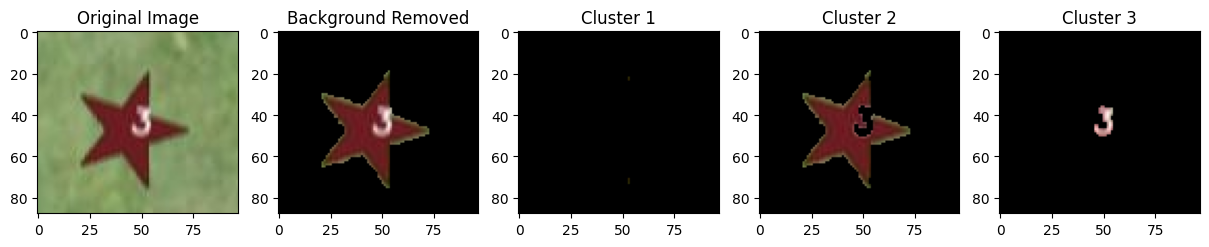

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/content/testimg2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a mask for the foreground (background already removed)
mask = np.zeros(image.shape[:2], np.uint8)

# Initialize background and foreground models
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Define a rectangle that includes the entire image
rect = (1, 1, image.shape[1]-1, image.shape[0]-1)

# Interactive GrabCut: Allow user to mark foreground and background
cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Create a binary mask for the user-defined foreground
mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Multiply the original image with the binary mask to remove the background
result = image * mask[:, :, np.newaxis]

# Reshape the image to a 2D array of pixels (height x width, 3)
pixels = result.reshape(-1, 3)

# Define the number of clusters (e.g., 3 for shape, letter, and background colors)
num_clusters = 3
# Apply k-means clustering to classify the colors
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(pixels)
labels = kmeans.predict(pixels)

# Reshape labels to the original image shape
labels = labels.reshape(image.shape[:2])

# Visualize the clustered image
clustered_images = [np.zeros_like(result) for _ in range(num_clusters)]

for i in range(num_clusters):
    clustered_images[i][labels == i] = result[labels == i]

# Display the original image, background removed image, and clustered images
fig, axes = plt.subplots(1, num_clusters + 2, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[1].imshow(result)
axes[1].set_title("Background Removed")

for i in range(num_clusters):
    axes[i + 2].imshow(clustered_images[i])
    axes[i + 2].set_title(f"Cluster {i + 1}")

plt.show()


In [ ]:
#REMOVING THE BLACK CLUSTER (BACKGROUND)


import os
import cv2
import numpy as np

# Define the input directory containing clustered images
input_dir = '/content/clustered_images(NORMAL)'

# Define the output directory to save non-black images
output_dir = 'clustered_images_no_black/'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over the clustered image files
for image_file in os.listdir(input_dir):
    image_path = os.path.join(input_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate the percentage of black pixels (thresholded to 10 to allow some non-black)
    black_percentage = np.mean(image <= 10)

    # Define a threshold for excluding images with most black pixels
    threshold = 0.95  # Adjust as needed

    # If the percentage of black pixels is below the threshold, save the image
    if black_percentage < threshold:
        output_path = os.path.join(output_dir, image_file)
        cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

print("Black image removal complete.")


Black image removal complete.
